In this notebook, we will try to predict the gender of a Hollywood movie character based in his / her dialogues in the movie. The [dataset](https://www.kaggle.com/Cornell-University/movie-dialog-corpus) was released by [Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). This classifier will help us understand if there is some kind of gender bias between male and female characters in Hollywood movies.

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

from imblearn.under_sampling import RandomUnderSampler
import eli5

import IPython
from IPython.display import display
import graphviz
from sklearn.tree import export_graphviz
import re


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### Reading the dataset

In [2]:
lines_df = pd.read_csv('../input/movie_lines.tsv', sep='\t', error_bad_lines=False,
                       warn_bad_lines=False, header=None)
characters_df = pd.read_csv('../input/movie_characters_metadata.tsv', sep='\t', warn_bad_lines=False,
                            error_bad_lines=False, header=None)

characters_df.head()

,0,1,2,3,4,5
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


Adding column names to characters dataframe

In [3]:
characters_df.columns=['chId','chName','mId','mName','gender','posCredits']
characters_df.head()

,chId,chName,mId,mName,gender,posCredits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


In [4]:
characters_df.shape

(9034, 6)

Checking the distribution of gender in the characters dataset

In [5]:
characters_df.gender.value_counts()

?    6008
m    1899
f     921
M     145
F      44
Name: gender, dtype: int64

We need to clean this column. Let's also remove the characters were gender information is not available.
We'll assign a label of 0 to male characters & 1 to female characters.

In [6]:
characters_df = characters_df[characters_df.gender != '?']
characters_df.gender = characters_df.gender.apply(lambda g: 0 if g in ['m', 'M'] else 1)  ## Label encoding

characters_df.shape

(3026, 6)

In [7]:
characters_df.gender.value_counts()

0    2044
1     982
Name: gender, dtype: int64

Let's also take a look at the position of the character in the post credits of the movie

In [8]:
characters_df.posCredits.value_counts()

1       497
2       443
3       352
?       330
4       268
5       211
6       169
7       125
8       100
9        79
10       54
11       40
1000     38
13       33
12       32
16       26
14       24
18       24
17       19
19       18
15       14
21       13
22        9
20        8
29        7
27        6
24        5
25        5
26        5
45        4
23        4
31        4
35        4
38        3
43        3
33        3
34        3
36        2
59        2
39        2
30        2
42        2
28        2
32        2
51        1
82        1
44        1
70        1
46        1
41        1
63        1
37        1
50        1
49        1
47        1
62        1
71        1
Name: posCredits, dtype: int64

The position of characters in the credits section seems to be a useful feature for classification. We can try to use it as a categorical variable later. But let's combine the low frequency ones together first.

In [9]:
characters_df.posCredits = characters_df.posCredits.apply(lambda p: '10+' if not p in ['1', '2', '3', '4', '5', '6', '7', '8', '9'] else p)  ## Label encoding
characters_df.posCredits.value_counts()

10+    782
1      497
2      443
3      352
4      268
5      211
6      169
7      125
8      100
9       79
Name: posCredits, dtype: int64

Let's clean the lines dataframe now!

In [10]:
lines_df.columns = ['lineId','chId','mId','chName','dialogue']
lines_df.head()

,lineId,chId,mId,chName,dialogue
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


Let's join lines_df and characters_df together.

In [11]:
df = pd.merge(lines_df, characters_df, how='inner', on=['chId','mId', 'chName'],
         left_index=False, right_index=False, sort=True,
         copy=False, indicator=False)
df.head()

,lineId,chId,mId,chName,dialogue,mName,gender,posCredits
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,1,4
1,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,1,4
2,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,1,4
3,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,1,4
4,L869,u0,m0,BIANCA,Like my fear of wearing pastels?,10 things i hate about you,1,4


In [12]:
df.shape

(229309, 8)

Remove empty dialogues from the dataset

In [13]:
df = df[df['dialogue'].notnull()]
df.shape

(229106, 8)

Adding movie metadata like year of release to the dataset

In [14]:
movies = pd.read_csv("../input/movie_titles_metadata.tsv", sep='\t', error_bad_lines=False,
                       warn_bad_lines=False, header=None)
movies.columns = ['mId','mName','releaseYear','rating','votes','genres']

movies.head()

,mId,mName,releaseYear,rating,votes,genres
0,m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
1,m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
2,m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
3,m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
4,m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']


In [15]:
movie_yr = movies[['mId', 'releaseYear']]
movie_yr.releaseYear = pd.to_numeric(movie_yr.releaseYear.apply(lambda y: str(y)[0:4]), errors='coerce')
movie_yr = movie_yr.dropna()
movie_yr.releaseYear.value_counts()

1999.0    42
2000.0    41
1997.0    38
1998.0    37
2001.0    30
1996.0    24
1995.0    22
1992.0    19
1989.0    19
1994.0    19
1993.0    18
2002.0    18
2003.0    16
1987.0    15
2004.0    14
1991.0    14
1982.0    14
1988.0    13
1985.0    11
1986.0    11
1990.0    11
1984.0    11
2005.0     9
1975.0     9
1979.0     8
1971.0     7
1980.0     6
2006.0     6
1983.0     5
2007.0     5
1978.0     5
1974.0     5
1977.0     4
1973.0     4
1932.0     4
1976.0     4
1964.0     3
2009.0     3
1953.0     3
1972.0     3
1939.0     3
1954.0     3
1934.0     3
1943.0     3
1981.0     3
1949.0     3
1968.0     3
1955.0     3
1960.0     3
1959.0     3
1945.0     2
1940.0     2
1931.0     2
1927.0     2
1961.0     2
1966.0     2
1963.0     2
1933.0     2
1970.0     2
1950.0     2
1967.0     2
1941.0     2
1936.0     1
2010.0     1
1944.0     1
2008.0     1
1942.0     1
1937.0     1
1946.0     1
1965.0     1
1957.0     1
1958.0     1
1956.0     1
1969.0     1
Name: releaseYear, dtype: int64

In [16]:
df = pd.merge(df, movie_yr, how='inner', on=['mId'],
         left_index=False, right_index=False, sort=True,
         copy=False, indicator=False)
df.head()

,lineId,chId,mId,chName,dialogue,mName,gender,posCredits,releaseYear
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,1,4,1999.0
1,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,1,4,1999.0
2,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,1,4,1999.0
3,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,1,4,1999.0
4,L869,u0,m0,BIANCA,Like my fear of wearing pastels?,10 things i hate about you,1,4,1999.0


## Feature Engineering
- Length of lines
- Count of lines
- One hot encodings for tokens

In [17]:
df['lineLength'] = df.dialogue.str.len()             ## Length of each line by characters
df['wordCountLine'] = df.dialogue.str.count(' ') + 1 ## Length of each line by words
df.head()

,lineId,chId,mId,chName,dialogue,mName,gender,posCredits,releaseYear,lineLength,wordCountLine
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,1,4,1999.0,12,3
1,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,1,4,1999.0,10,3
2,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,1,4,1999.0,9,2
3,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,1,4,1999.0,46,10
4,L869,u0,m0,BIANCA,Like my fear of wearing pastels?,10 things i hate about you,1,4,1999.0,32,6


Next, let's convert the dialogues into clean tokens 
<ol>
<li>Remove Stopwords : because they occur very often, but serve no meaning. e.g. : is,am,are,the.</li>
<li>Turn all word to smaller cases : I, i -> i</li>
<li>walk,walks -> walk or geographical,geographic -> geographic</li>  #Lemmatization
</ol>

In [18]:
wordnet_lemmatizer = WordNetLemmatizer()
def clean_dialogue( dialogue ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    # Source : https://www.kaggle.com/akerlyn/wordcloud-based-on-character
    #
    # 1. Remove HTML
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", dialogue) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))   
    
    # 5. Use lemmatization and remove stop words
    meaningful_words = [wordnet_lemmatizer.lemmatize(w) for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

df['cleaned_dialogue'] = df['dialogue'].apply(clean_dialogue)
df[['cleaned_dialogue','dialogue']].head()

,cleaned_dialogue,dialogue
0,,They do not!
1,hope,I hope so.
2,let go,Let's go.
3,okay gonna need learn lie,Okay -- you're gonna need to learn how to lie.
4,like fear wearing pastel,Like my fear of wearing pastels?


### Create training dataset
Now, we can aggregate all data for a particular movie character into 1 record. We will combine their dialogue tokens from the entire movie, calculate their median dialogue length by characters & words, and count their total no of lines in the movie.

In [19]:
train = df.groupby(['chId', 'mId', 'chName', 'gender', 'posCredits','releaseYear']). \
            agg({'lineLength' : ['median'], 
                 'wordCountLine' : ['median'],
                 'chId' : ['count'],
                 'cleaned_dialogue' : [lambda x : ' '.join(x)]
                })

## Renaming columns by aggregate functions
train.columns = ["_".join(x) for x in train.columns.ravel()]

train.reset_index(inplace=True)
train

,chId,mId,chName,gender,posCredits,releaseYear,lineLength_median,wordCountLine_median,chId_count,cleaned_dialogue_<lambda>
0,u0,m0,BIANCA,1,4,1999.0,34.0,7.0,94,hope let go okay gonna need learn lie like fe...
1,u100,m6,AMY,1,7,1999.0,23.0,4.0,31,died sleep three day ago paper tom dead calli...
2,u1003,m65,RICHARD,0,3,1996.0,24.5,5.0,70,asked would said room room serious foolin arou...
3,u1005,m65,SETH,0,2,1996.0,37.0,8.0,163,let follow said new jesus christ carlos brothe...
4,u1008,m66,C.O.,0,10+,1997.0,48.0,9.0,33,course uh v p security arrangement generally t...
...,...,...,...,...,...,...,...,...,...,...
2946,u980,m63,VICTOR,0,3,1931.0,32.0,6.0,126,never said name remembers kill draw line take...
2947,u983,m64,ALICE,1,10+,2009.0,30.0,6.0,51,maybe wait mr christy killer still bill bill b...
2948,u985,m64,BILL,0,10+,2009.0,20.0,4.0,39,twenty mile crossroad steve back hour thing st...
2949,u997,m65,JACOB,0,1,1996.0,36.0,6.0,90,meant son daughter oh daughter bathroom vacati...


### Let's check some feature distributions by gender

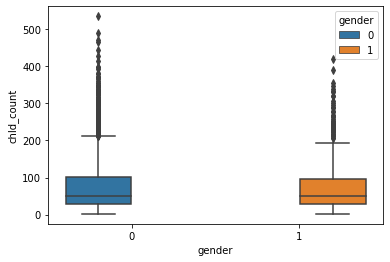

In [20]:
sns.boxplot(data = train, x = 'gender', y = 'chId_count', hue = 'gender')

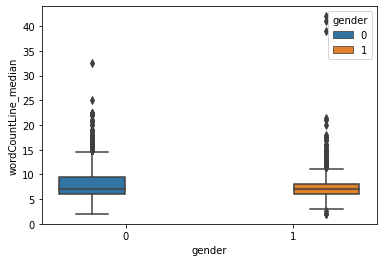

In [21]:
sns.boxplot(data = train, x = 'gender', y = 'wordCountLine_median', hue = 'gender')

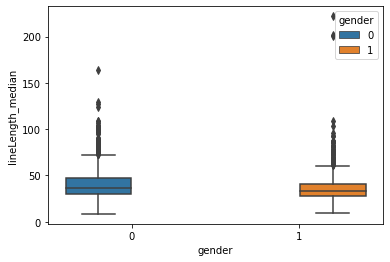

In [22]:
sns.boxplot(data = train, x = 'gender', y = 'lineLength_median', hue = 'gender')

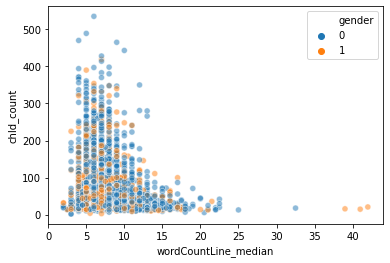

In [23]:
sns.scatterplot(data = train, x = 'wordCountLine_median', y = 'chId_count', hue = 'gender', alpha = 0.5) 

### Train test split

Now, we can split our data into a training set & a validation set.

In [24]:
## Separating labels from features
y = train['gender']
X = train.copy()
X.drop('gender', axis=1, inplace=True)

## Removing unnecessary columns
X.drop('chId', axis=1, inplace=True)
X.drop('mId', axis=1, inplace=True)
X.drop('chName', axis=1, inplace=True)
X.head()

,posCredits,releaseYear,lineLength_median,wordCountLine_median,chId_count,cleaned_dialogue_<lambda>
0,4,1999.0,34.0,7.0,94,hope let go okay gonna need learn lie like fe...
1,7,1999.0,23.0,4.0,31,died sleep three day ago paper tom dead calli...
2,3,1996.0,24.5,5.0,70,asked would said room room serious foolin arou...
3,2,1996.0,37.0,8.0,163,let follow said new jesus christ carlos brothe...
4,10+,1997.0,48.0,9.0,33,course uh v p security arrangement generally t...


We will pick equal no of records for both male & female characters to avoid any kind of bias due to no of records.

In [25]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)
y_under.value_counts()

1    948
0    948
Name: gender, dtype: int64

We'll also try to keep equal no of male & female records in the train & validation datasets

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_under, y_under, test_size=0.2, random_state = 10, stratify=y_under)

y_val.value_counts()

1    190
0    190
Name: gender, dtype: int64

In [27]:
X_val.head()

,posCredits,releaseYear,lineLength_median,wordCountLine_median,chId_count,cleaned_dialogue_<lambda>
1236,2,2001.0,33.0,6.0,60,latitude degree maybe satellite said three ye...
924,10+,1974.0,23.0,5.0,23,sure okay okay got boat plus owe know oh gee m...
868,4,2001.0,34.0,6.0,34,going coast alan idea alive headed need stick...
363,1,1999.0,33.0,7.0,146,poor woman carole wound could hope pacify evas...
989,10+,2000.0,42.0,8.0,15,okay took trouble come got principle selling o...


### Pipeline for classifiers

Since our dataset includes both numerical features & NLP tokens, we'll use a special converter class in our pipeline.

In [28]:
class Converter(BaseEstimator, TransformerMixin):
    ## Source : https://www.kaggle.com/tylersullivan/classifying-phishing-urls-three-models
    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame.values.ravel()

Pipeline for numeric features

In [29]:
numeric_features = ['lineLength_median', 'wordCountLine_median', 'chId_count', 'releaseYear']

numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

Pipeline for tokens dereived from dialogues

In [30]:
categorical_features = ['posCredits']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [31]:
vectorizer_features = ['cleaned_dialogue_<lambda>']
vectorizer_transformer = Pipeline(steps=[
    ('con', Converter()),
    ('tf', TfidfVectorizer())])

Now, we can combine preprocessing pipelines with the classifers. We will try 4 basic models:
- Linear Support Vector Classifier
- Logistic Regression Classifier
- Naive Bayes Classifier
- Random Forest Clasifier

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('vec', vectorizer_transformer, vectorizer_features)
    ])

svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', CalibratedClassifierCV(LinearSVC()))])  ## LinearSVC has no predict_proba method

log_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

nb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())])

rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=120, min_samples_leaf=10, 
                                                            max_features=0.7, n_jobs=-1, oob_score=True))])

Fitting the preprocessing & classifier pipelines on training data

In [33]:
svc_clf.fit(X_train, y_train)
log_clf.fit(X_train, y_train)
nb_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['lineLength_median',
                                                   'wordCountLine_median',
                                                   'chId_count',
                                                   'releaseYear']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['posCredits']),
                                                 ('vec',
                                                  Pipeline(steps=[('con',
                         

### Check results on the validation set

In [34]:
def results(name: str, model: BaseEstimator) -> None:
    '''
    Custom function to check model performance on validation set
    '''
    preds = model.predict(X_val)

    print(name + " score: %.3f" % model.score(X_val, y_val))
    print(classification_report(y_val, preds))
    labels = ['Male', 'Female']

    conf_matrix = confusion_matrix(y_val, preds)
    plt.figure(figsize= (10,6))
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap='Blues')
    plt.title("Confusion Matrix for " + name)
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

SVC score: 0.721
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       190
           1       0.71      0.75      0.73       190

    accuracy                           0.72       380
   macro avg       0.72      0.72      0.72       380
weighted avg       0.72      0.72      0.72       380

Logistic Regression score: 0.718
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       190
           1       0.70      0.76      0.73       190

    accuracy                           0.72       380
   macro avg       0.72      0.72      0.72       380
weighted avg       0.72      0.72      0.72       380

Naive Bayes score: 0.708
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       190
           1       0.72      0.68      0.70       190

    accuracy                           0.71       380
   macro avg       0.71      0.71      0.71       380

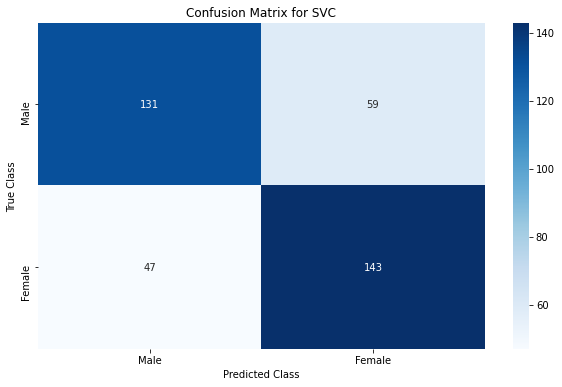

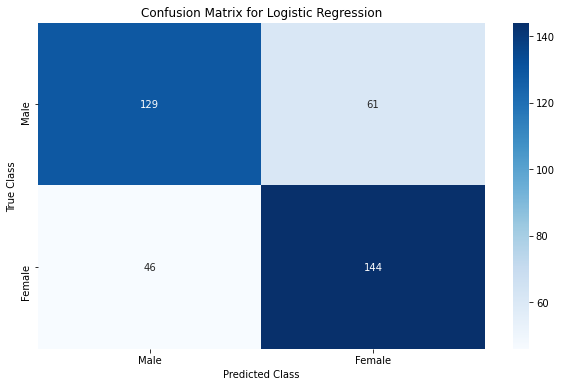

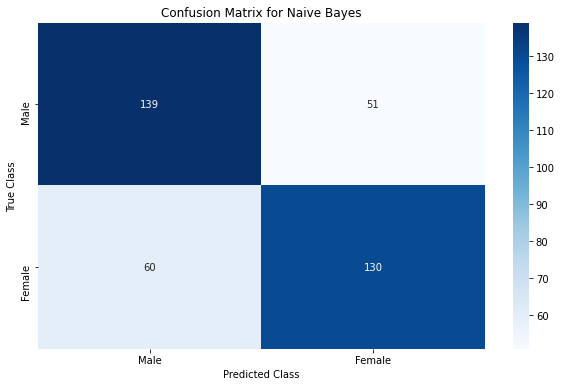

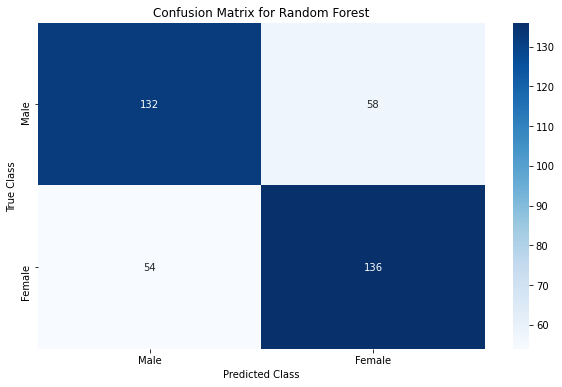

In [35]:
results("SVC" , svc_clf)
results("Logistic Regression" , log_clf)
results("Naive Bayes" , nb_clf)
results("Random Forest" , rf_clf)

We are getting accuracy in the range of 70-75% for most of the models, which is pretty good. 
Some possible ways to improve this performance could be:
- using bi-grams or tri-grams for dialogue tokens
- Trying out feed forward neural networks, LSTM or CNN
- additional feature engineering related to context of dialogues in the movie

Still, our current classifier performance is good enough to understand that there is indeed a gender bias in the characters of Hollywood movies which our models are capturing fairly well.

Let's explore what features contribute the most to our classifiers through some model explainability techniques.

## Feature importance

Creating a list of all features including numeric & vectorised features

In [36]:
vect_columns = list(svc_clf.named_steps['preprocessor'].named_transformers_['vec'].named_steps['tf'].get_feature_names())
onehot_columns = list(svc_clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)
numeric_features_list.extend(vect_columns)

#### Feature importance for Logistic Regression

In [37]:
lr_weights = eli5.explain_weights_df(log_clf.named_steps['classifier'], top=30, feature_names=numeric_features_list)
lr_weights.head(15)

,target,feature,weight
0,1,oh,2.914220
1,1,really,1.598428
2,1,love,1.582584
3,1,hi,1.173297
4,1,said,1.161967
5,1,want,1.053116
6,1,like,1.020965
7,1,darling,0.992410
8,1,never,0.987203
9,1,child,0.975300


In [38]:
lr_weights.tail(15)

,target,feature,weight
15,1,peter,0.878517
16,1,son,-0.876330
17,1,good,-0.897884
18,1,right,-0.899643
19,1,chId_count,-0.916359
20,1,fuck,-0.996575
21,1,fuckin,-1.049543
22,1,yeah,-1.091158
23,1,hell,-1.137874
24,1,got,-1.162604


We see that dialogue keywords like "oh", "love", "like", "darling", "want", "honey" are strong indicators that the character is a female, while keywords like "sir", "man", "hell", "fuckin", "gotta" & "yeah" are usually found in the dialogues of male characters!

#### Let's also try to visualize a single decision tree

We can training a single decision tree using the Random Forest Classifier.

Decision Tree Classifier score: 0.526
              precision    recall  f1-score   support

           0       0.54      0.37      0.44       190
           1       0.52      0.68      0.59       190

    accuracy                           0.53       380
   macro avg       0.53      0.53      0.51       380
weighted avg       0.53      0.53      0.51       380



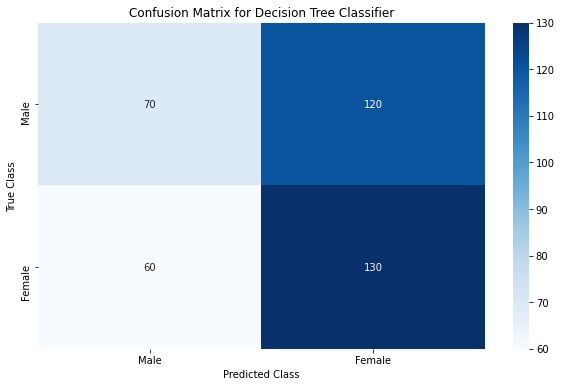

In [39]:
m = RandomForestClassifier(n_estimators=1, min_samples_leaf=5, max_depth = 3, 
                           oob_score=True, random_state = np.random.seed(123))
dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', m)])

dt_clf.fit(X_train, y_train)
results("Decision Tree Classifier", dt_clf)

While a single decision is a poor classifier with accuracy barely more than 50%, we see that bagging enough of such weak classifiers to form a Random Forest model helps us improve the model performance drastically! Let's look at how the splits are made for a single decision tree.

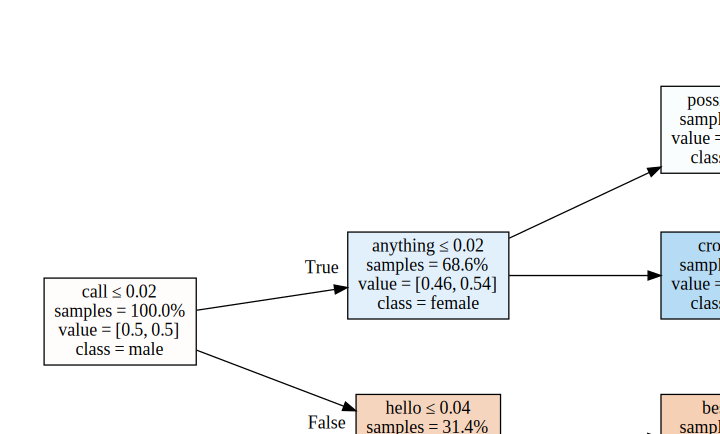

In [40]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ 
    Draws a representation of a decition tree in IPython from fastai v0.7
    """
    s=export_graphviz(t, out_file=None, feature_names=numeric_features_list, filled=True,
                      special_characters=True, rotate=True, precision=precision, 
                      proportion=True, class_names = ["male", "female"], impurity = False)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

draw_tree(m.estimators_[0], X_train, precision=2)

Here the blue colored nodes indicate their majority class is "female" while the orange colored nodes have a majority of "male" labels. The decision tree starts with a mixed sample, but the leaves of the tree are biased towards one class or the other. Most splits seem to be happening using dialogue tokens.

#### Feature importance for the Random Forest model

In [41]:
eli5.explain_weights_df(rf_clf.named_steps['classifier'], top=30, feature_names=numeric_features_list)

,feature,weight,std
0,oh,0.077328,0.027570
1,man,0.040615,0.030255
2,love,0.022664,0.026011
3,shit,0.019557,0.027031
4,said,0.017135,0.018359
5,lineLength_median,0.015757,0.017705
6,got,0.013712,0.018381
7,really,0.013227,0.018366
8,hey,0.012435,0.019035
9,good,0.012253,0.017000


We see that the median length of a dialogue, total no of lines (`chId_count`) & position in the post credits in a movie are important features along with the tokens extracted from the character's dialogues for the Random Forest model!